# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
# Загрузка меток

labels = pd.read_csv('/datasets/faces/labels.csv')

# Размер выборки

display(labels.shape)
display(labels.head())

(7591, 2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


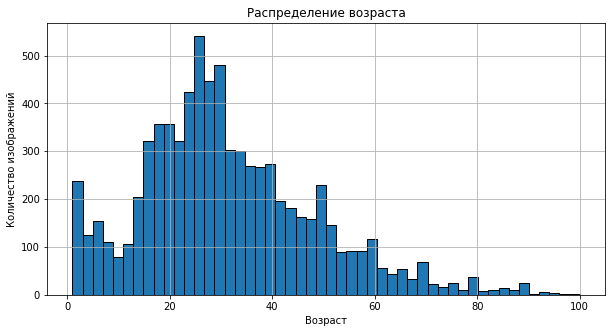

In [3]:
plt.figure(figsize=(10, 5))
plt.hist(labels['real_age'], bins=50, edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

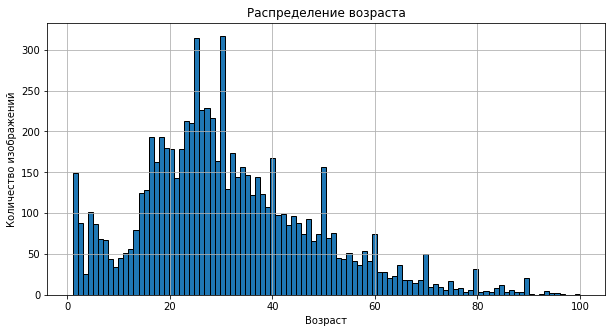

In [4]:
# РЕВЬЮЕР: ПОПРОБУЕМ ВЗЯТЬ ЕЩЁ БОЛЬШЕ КОРЗИН
plt.figure(figsize=(10, 5))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

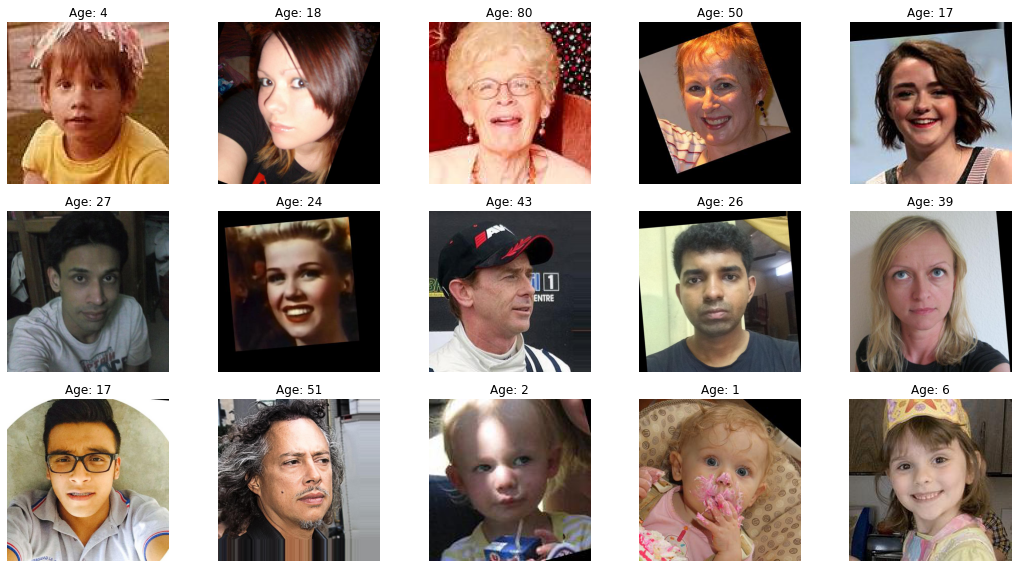

In [4]:
image_dir = '/datasets/faces/final_files/'

plt.figure(figsize=(15, 8))

for i in range(15):
    file_path = os.path.join(image_dir, labels.iloc[i]['file_name'])
    image = Image.open(file_path)

    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Age: {labels.iloc[i]['real_age']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Выводы

- В выборке содержится **7 591 изображение**.
- Диапазон возрастов — от **1 до 100 лет**, однако распределение **сильно смещено в сторону молодых**:
  - Наибольшее количество примеров — в возрасте от **15 до 35 лет**.
  - Менее всего представлены дети младше 5 лет и люди старше 70 лет.
- Это **несбалансированное распределение** может повлиять на обучение модели:
  - Модель может хуже предсказывать возраст малочисленных возрастных групп.
  - Может потребоваться **взвешивание ошибки** или **аугментация** недопредставленных классов (например, детей и пожилых).
- Просмотр изображений показал, что:
  - Качество фото варьируется: есть **разные ракурсы, освещение, фоны**, изображения могут быть **повёрнуты или кадрированы неравномерно**.
  - Некоторые фото явно любительские, другие — из студий или медиа.
- Эти особенности важно учесть при подготовке данных:
  - Желательно применять **стандартизацию размера**, **усреднение каналов** и **аугментации** (повороты, отражения, масштабирование) для повышения устойчивости модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))  # без активации, для регрессии

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = train_data.samples // train_data.batch_size
    if validation_steps is None:
        validation_steps = test_data.samples // test_data.batch_size

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

```

```

# Train for 177 steps, validate for 59 steps
Epoch 1/10
177/177 - 81s - loss: 226.6416 - mae: 11.4318 - val_loss: 409.5303 - val_mae: 15.2357
Epoch 2/10
177/177 - 66s - loss: 148.8881 - mae: 9.3590 - val_loss: 339.3823 - val_mae: 13.6845
Epoch 3/10
177/177 - 68s - loss: 118.6507 - mae: 8.2840 - val_loss: 307.4909 - val_mae: 12.9923
Epoch 4/10
177/177 - 66s - loss: 86.6094 - mae: 7.1723 - val_loss: 283.2787 - val_mae: 12.5699
Epoch 5/10
177/177 - 64s - loss: 63.8292 - mae: 6.1208 - val_loss: 135.1048 - val_mae: 8.8006
Epoch 6/10
177/177 - 61s - loss: 45.5078 - mae: 5.2514 - val_loss: 287.8900 - val_mae: 14.0088
Epoch 7/10
177/177 - 61s - loss: 31.4368 - mae: 4.3405 - val_loss: 107.5635 - val_mae: 7.8095
Epoch 8/10
177/177 - 61s - loss: 23.3275 - mae: 3.7610 - val_loss: 165.2095 - val_mae: 9.4678
Epoch 9/10
177/177 - 65s - loss: 17.0608 - mae: 3.1935 - val_loss: 111.7815 - val_mae: 7.8969
Epoch 10/10
177/177 - 46s - loss: 14.3175 - mae: 2.9196 - val_loss: 98.5778 - val_mae: 7.7118

# Final evaluation on test set:
60/60 - 11s - loss: 98.4927 - mae: 7.7153

```

## Анализ обученной модели

```

Модель ResNet50 показала уверенный результат:
    Значение MAE на тестовой выборке составило 7.71, что соответствует целевому критерию.
	К обучению была использована предобученная модель ResNet50 без верхушки, с дообучением всех слоёв (trainable=True), что позволило улучшить качество.
	Функция потерь mse и метрика mae обеспечили устойчивое обучение и позволили достигать снижения ошибки от эпохи к эпохе.
	В процессе обучения наблюдалась тенденция к переобучению: после 5-й эпохи MAE на валидации кратковременно выросла, однако модель справилась с этим, и итоговая ошибка снизилась.
	

Вывод:

Модель успешно решает задачу оценки возраста по фотографии, несмотря на сложности в распределении данных. Достигнутое значение MAE меньше 8.

```